In [2]:
# Preamble
from astropy.table import Table, column
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

### In this notebook, we wish to compare the individual arcs within galaxies:

- Are there any systematic trends with arm, acr number etc?

In [4]:
# First, load the arc metadata:
P_array = np.load('../fits/sparcfire/np_metadata/P.npy')
L_array = np.load('../fits/sparcfire/np_metadata/L.npy')
N_wtd_avg_start = np.load('../fits/sparcfire/np_metadata/N_wtd_avg_start.npy')

In [5]:
mendel_masses = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
samples = Table.read('../fits/SF_fits/samples.fits') # galaxy samples data
#pitch_angles = Table.read('../fits/sparcfire/')

In [6]:
sparcfire_g = Table.read('../sparcfire_directories/main/sparcfire_g_matched.fits') # sparcfire data

In [40]:
in_spiral = np.all([mendel_masses['in_mass_limit'],samples['in_spiral'],
                    samples['axial_ok'],samples['unbarred']],
                    axis=0)
in_sparcfire = sparcfire_g['fit_state'] == 'OK'
sparcfire_spirals = np.all([in_spiral,in_sparcfire],axis=0)

P_spirals, L_spirals, N_spirals = [d[sparcfire_spirals] for d in [P_array, L_array, N_wtd_avg_start]]

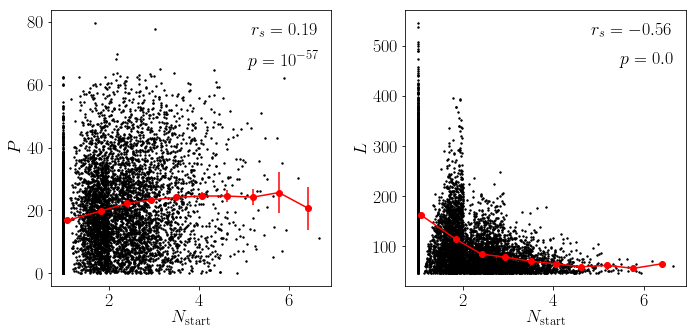

In [41]:
from xy_plots import x_vs_y
from scipy.stats import spearmanr

fig, axarr = plt.subplots(1,2,figsize=(10,5))

ok_L = L_spirals > 45
x = N_spirals[ok_L].ravel()

ax = axarr[0]
y0 = np.absolute(P_spirals[ok_L].ravel())
xy = x_vs_y(x,y0)
xy.scatter(ax,color='k',alpha=1,s=2)
xy.continuous_vs_continuous_binned(ax,color='r',marker='o')
xy.show_spearmanr(ax)
ax.set_xlabel('$N_\mathrm{start}$')
ax.set_ylabel('$P$')

ax = axarr[1]
y1 = L_spirals[ok_L].ravel()
xy = x_vs_y(x,y1)
xy.scatter(ax,color='k',alpha=1,s=2)
xy.continuous_vs_continuous_binned(ax,color='r',marker='o')
xy.show_spearmanr(ax)
ax.set_xlabel('$N_\mathrm{start}$')
ax.set_ylabel('$L$')

fig.tight_layout()

#### Need to do this binned by spiral arm number: ie. is there a 'continuous' offset due to the arms themselves?

In [64]:
# Create mask to match arcs to their corresponding m values

N_row, N_col = L_spirals.shape
m_mask = np.ones((N_row,N_col),dtype=np.int)
for n in range(N_col):
    m_mask[:,n] = samples['m'][sparcfire_spirals] 

In [65]:
m_mask[:,0]

array([1, 4, 2, ..., 1, 2, 1])

In [66]:
for m in range(5):
    print((m_values == m).sum()/11)

29.8181818182
310.272727273
153.272727273
59.6363636364
82.0


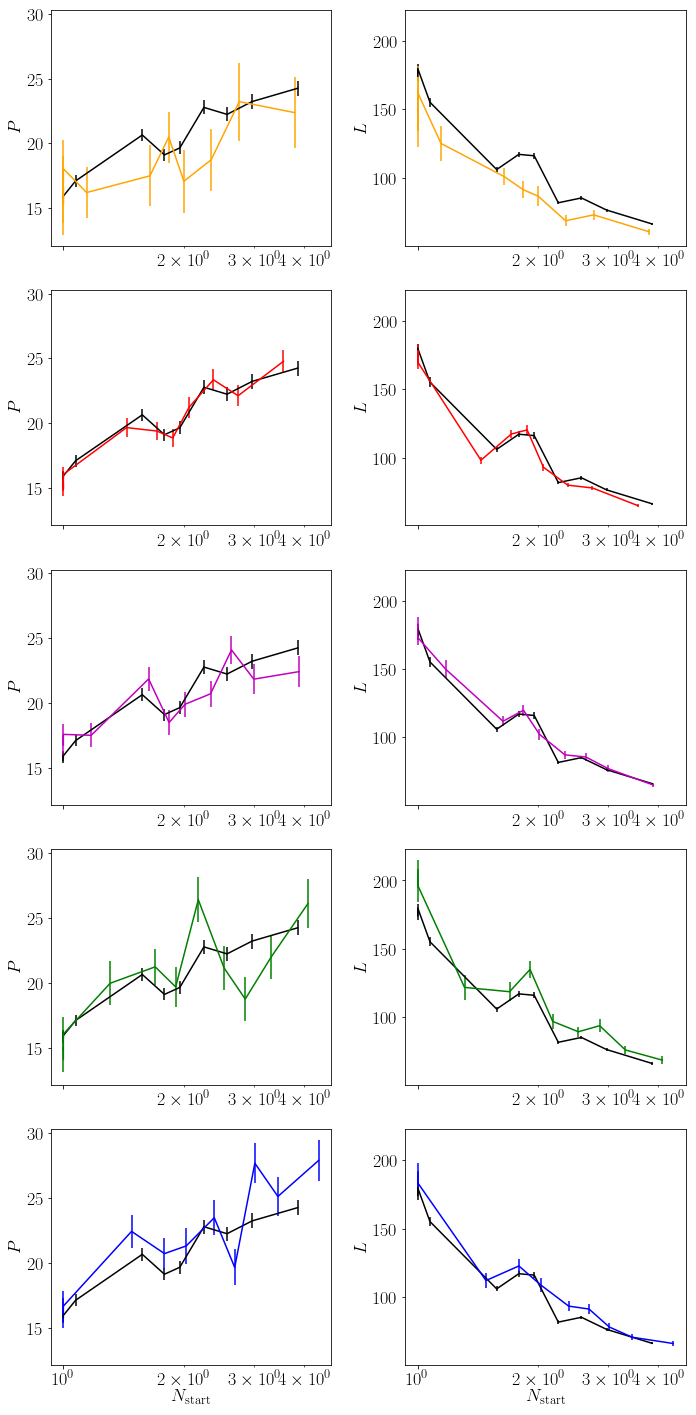

In [67]:
fig, axarr = plt.subplots(5,2,figsize=(10,20),
                          sharex=True,sharey='col')

x = N_spirals[ok_L].ravel()
y0 = np.absolute(P_spirals[ok_L]).ravel()
y1 = L_spirals[ok_L].ravel()
m_values = m_mask[ok_L].ravel()

def plot_arm_number(axarr,x,y,m_values):
    colors = ['orange','red','m','g','b']
    xy_ref = x_vs_y(x,y)
    for m, ax in enumerate(axarr):
        xy_ref.continuous_vs_continuous_binned(ax,color='k',equal_N=True)
        ok_m = m_values == m
        x_m, y_m = x[ok_m], y[ok_m]
        xy_m = x_vs_y(x_m,y_m)
        xy_m.continuous_vs_continuous_binned(ax,color=colors[m],equal_N=True)
        ax.set_xscale('log')
        #ax.hist(x_m,np.linspace(1,5,21),color=colors[m],normed=True)
    axarr[-1].set_xlabel('$N_\mathrm{start}$')
    return axarr

plot_arm_number(axarr[:,0],x,y0,m_values)
_ = plot_arm_number(axarr[:,1],x,y1,m_values)
for ax in axarr[:,0]:
    ax.set_ylabel('$P$')
for ax in axarr[:,1]:
    ax.set_ylabel('$L$')
    
fig.tight_layout()

#### How do $L$ and $P$ compare?

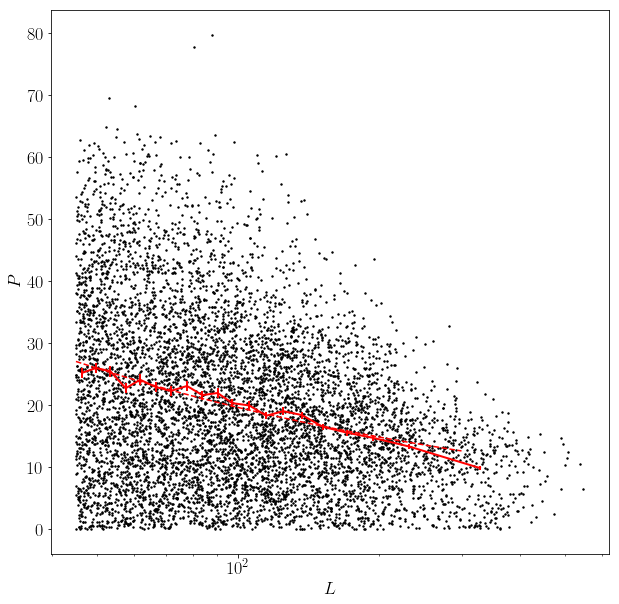

In [163]:
from contours import kde_contour
from scipy.optimize import curve_fit

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

x, y = L_spirals[ok_L], np.absolute(P_spirals[ok_L])

_ = plt.scatter(x,y,color='k',zorder=-1,s=2)
xy = x_vs_y(x,y)
#_ = kde_contour(x,y,fill=True)
xy.continuous_vs_continuous_binned(ax,color='r',lw=2,bins=20,equal_N=True)
ax.set_xlabel('$L$')
ax.set_ylabel('$P$')

ax.set_xscale('log')
#### curve fitting #######
def exp(x,m,c):
    return c*x**m

def linear(x,m,c):
    return m*x + c

p, _ = curve_fit(exp,x,y)
x_guide = np.linspace(45,300,1000)
_ = plt.plot(x_guide,exp(x_guide,*p),'r--')

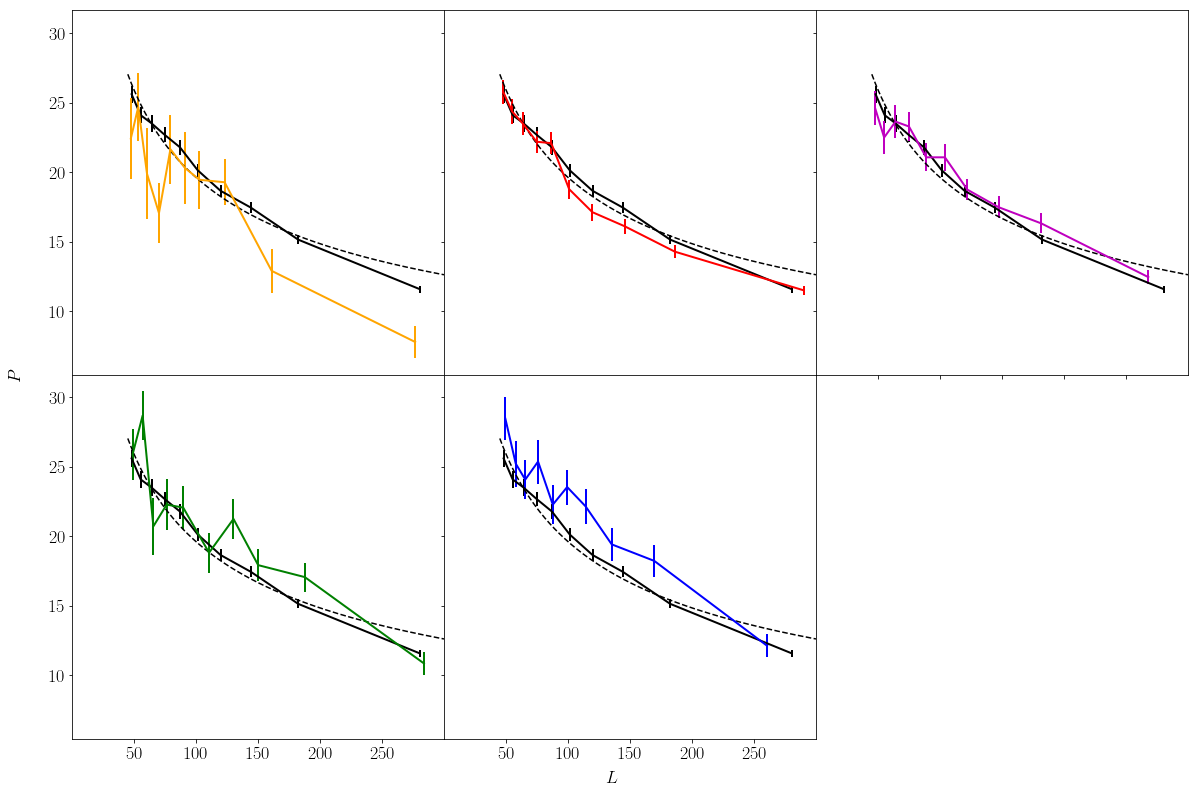

In [165]:
fig, axarr = plt.subplots(2,3,figsize=(20,13.4),
                          sharex=True,sharey=True)
colors = ['orange','red','m','g','b']
axarr = axarr.ravel()
fig.delaxes(axarr[-1])
axarr = axarr[:-1]
fig.subplots_adjust(hspace=0,wspace=0)
axarr[0].set_xlim(0,300)
#axarr[0].set_xscale('log')

m_values = m_mask[ok_L]

x_reference, y_reference = L_spirals[ok_L], np.absolute(P_spirals[ok_L])
xy_reference = x_vs_y(x_reference,y_reference)

for m, ax in enumerate(axarr):
    xy_reference.continuous_vs_continuous_binned(ax,color='k',lw=2,
                                                 equal_N=True)
    _ = ax.plot(x_guide,exp(x_guide,*p),'k--')
    x, y = x_reference[m_values == m], y_reference[m_values == m]
    xy  = x_vs_y(x,y)
    xy.continuous_vs_continuous_binned(ax,color=colors[m],lw=2,
                                       equal_N=True)
    
fig.text(0.5, 0.08, '$L$', ha='center')
fig.text(0.08, 0.5, '$P$', va='center', rotation='vertical')

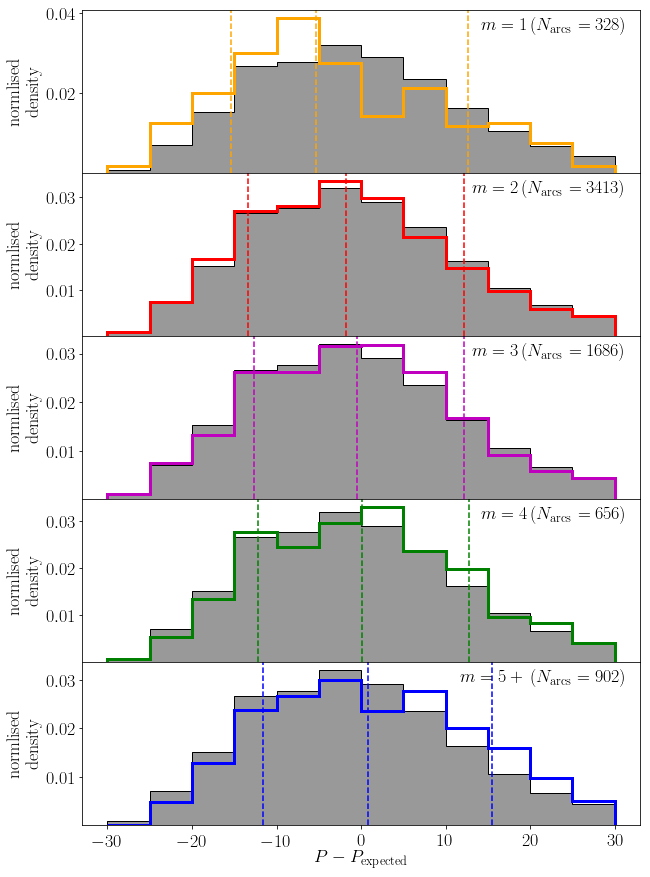

In [182]:
def measure_arc_offset(x,y,function):
    y_expected = function(x)
    offsets = y - y_expected
    return offsets

def f(x):
    return exp(x,*p)

mlabels = ['1','2','3','4','5+']

offset_total = measure_arc_offset(x_reference,y_reference,f)
offset1 = measure_arc_offset(x_reference[m_values == 0],y_reference[m_values == 0],f)
offset2 = measure_arc_offset(x_reference[m_values == 1],y_reference[m_values == 1],f)
offset3 = measure_arc_offset(x_reference[m_values == 2],y_reference[m_values == 2],f)
offset4 = measure_arc_offset(x_reference[m_values == 3],y_reference[m_values == 3],f)
offset5 = measure_arc_offset(x_reference[m_values == 4],y_reference[m_values == 4],f)
offsets = [offset1,offset2,offset3,offset4,offset5]

bins = np.linspace(-30,30,13)
fig, axarr = plt.subplots(5,1,figsize=(10,15))
fig.subplots_adjust(hspace=0,wspace=0)
for m, ax in enumerate(axarr):
    plt.sca(ax)
    offset = offsets[m]
    ax.hist(offset_total,bins,normed=True,
            histtype='stepfilled',color='k',alpha=0.4)
    ax.hist(offset_total,bins,normed=True,
            histtype='step',color='k',lw=1)
    ax.hist(offset,bins,normed=True,
            histtype='step',lw=3,color=colors[m])
    textstring = '$m={} \, (N_\mathrm{{arcs}}={})$'.format(mlabels[m],
                                                           len(offset))
    _ = ax.text(0.975,0.95,textstring,
                ha='right',va='top',transform=ax.transAxes)
    for percentile in [16,50,84]:
        plt.axvline(np.percentile(offset,percentile),
                     color=colors[m],linestyle='dashed')
    ax.set_ylabel('normlised \n density')
        
axarr[-1].set_xlabel('$P-P_\mathrm{expected}$')